In [1]:
%% Clear workspace and add NonSydID to the search path
clear;clc
addpath('C:\Users\ae4159\OneDrive - Coventry University\PhD project\Matlab files\NonSysID\Github\NonSysID');
%% Generate inputs and simulate MISO NARX model
% Parameters
fs = 500;                 % Sampling frequency (Hz)
Ts = 1/fs;                 % Sampling time (s)
T = 10;                   % Duration of the simulation (s)
n = T * fs;               % Number of samples

% Input Signal Generation
rng(0);                   % Set random seed for reproducibility
u1_raw = randn(1, n);     % White Gaussian noise for voltage (raw input)
u2_raw = randn(1, n);     % White Gaussian noise for velocity (raw input)

% Low-pass filter the inputs
fc = 5;                   % Cutoff frequency for low-pass filter (Hz)
[b, a] = butter(4, fc/(fs/2), 'low'); % 4th-order Butterworth filter

u1 = filter(b, a, u1_raw); % Filtered voltage input (u1)
u2 = filter(b, a, u2_raw); % Filtered velocity input (u2)

% Scale and shift u1
u1 = 0.5 * u1 + 1.6;      % Voltage input u1

% Compute u3 (sign of velocity)
u3 = sign(u2);% Sign of velocity (u2)

u = [ u1' , u2' , u3'];

% Simulate the model
y = MISO_NARX_model(u1, u2, u3, n)';
disp('Simulation done');

Simulation done


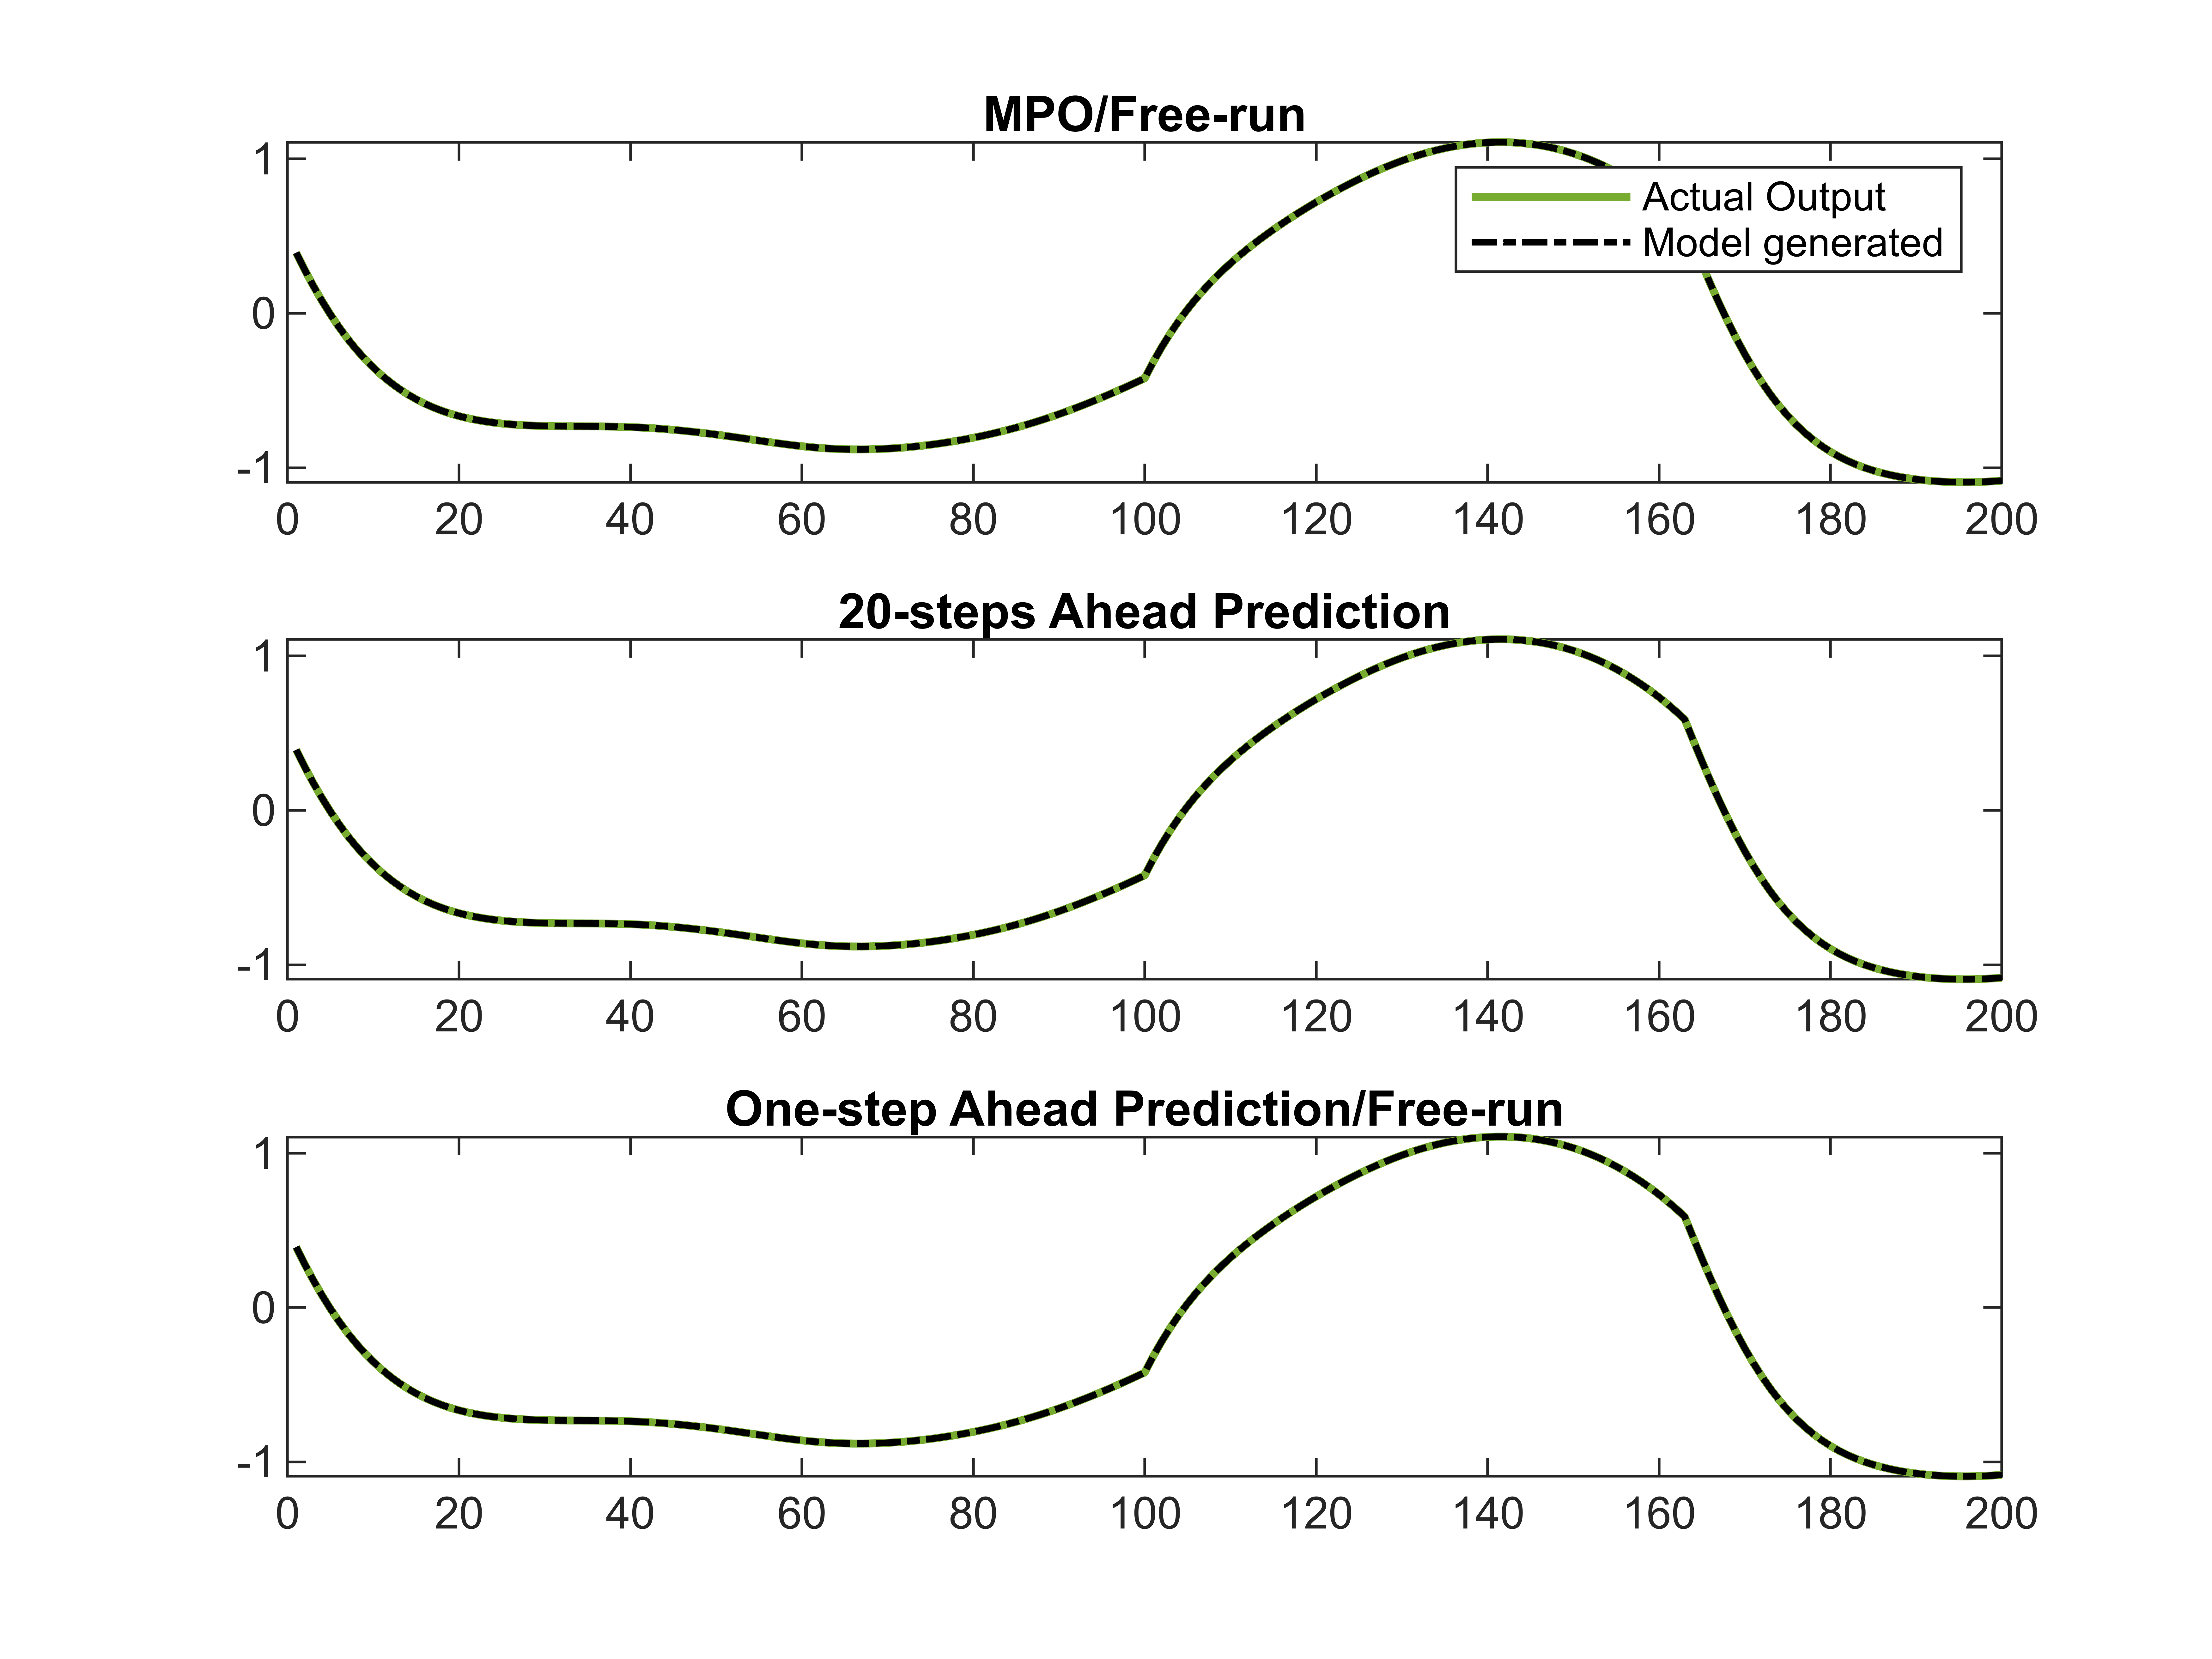

--------------------
MSSE = 7.5809e-29
MSkPE = 6.3429e-29
MSPE = 5.0376e-30
--------------------

In [2]:

%% System Identification - NonSysID
tt_splt = 500:700; %Training samples of data
u_ID=u(tt_splt,:);
y_ID=y(tt_splt);

% Model type ARX/AR
mod_type = 'ARX';

% Maximum and minimum output lags
na1=1;na2=1;

% Maximum and minimum input lags
nb1=1;nb2=1;

% Maximum order of polynomial nonlinearity considered
nl_ord_max=3;

% Run more than one iteration of iOFR for [linear model ,nonlinear model]
x_iOFR = [false,false];

% Stoping criteria for [linear model ,nonlinear model]. PRESS_thresh/BIC_thresh
stp_cri = {'PRESS_thresh', 'PRESS_thresh'};
% Set value for stopping criteria for [linear model ,nonlinear model]
% The stopping criteria relates to how many terms are added to the model
D1_thresh = [10^(-4),10^(-4)];

% Specify if bias/DC off set is required, 0, or not, 1.
is_bias=0;

% Specify number of inputs
n_inpts=3;

% Specify the number of steps for k-steps ahead prediction
KSA_h=20;

% Specify which RCT (Reduce Computational Time) method to use, 1-4, 0 for
% no RCT.
RCT=4;

% Specify whether to simulate model and display results respectively
sim=[1,1];
% Set to 1 to display all models generated from iOFRs, 0 otherwise
displ=0;

% Run NonSysID
tic
[model, Mod_Val_dat, iOFR_table_lin, iOFR_table_nl, best_mod_ind_lin, best_mod_ind_nl, val_stats] = ...
    NonSysID(mod_type,u_ID,y_ID,na1,na2,nb1,nb2,nl_ord_max,is_bias,n_inpts,KSA_h,RCT,x_iOFR,stp_cri,D1_thresh,displ,sim);

In [3]:
toc

Elapsed time is 0.250670 seconds.

In [4]:

disp('ARX model:'); disp(iOFR_table_lin{best_mod_ind_lin,1});

ARX model:
                  ERR          theta  
               __________    _________
    y1(t-1)       0.92405      0.85195
    u1(t-1)      0.073136    0.0012283
    u2(t-1)    0.00072116      0.43912
    u3(t-1)     0.0019089     0.063475

In [5]:
if best_mod_ind_nl~=0
    disp('NARX model:');
    tbl_NARX = join(iOFR_table_nl{best_mod_ind_nl,10},iOFR_table_nl{best_mod_ind_nl,1});disp(tbl_NARX);
end

NARX model:
                             MS_PRESS_E     theta        ERR    
                             __________    _______    __________
    y1(t-1)                   0.0016679     0.8536       0.14888
    u1(t-1)u2(t-1)           0.00014487     0.6143     0.0025017
    y1(t-1)u2(t-1)u3(t-1)      0.092725    -0.4407       0.84839
    u3(t-1)u3(t-1)u3(t-1)    5.3265e-30     0.0388    0.00022972

In [6]:
%% Simulate model
[sse, y_hat, error, U_delay_mat_sim] = model_simulation(model,u,y,KSA_h);

%----------
figure('OuterPosition',[237 224.2 897.6 577.6]);
subplot(4,1,1); plot(u(:,1), 'Color', '#0072BD');
ylabel(' !!!EQ_1!!! ','Interpreter','latex','FontSize',12);
subplot(4,1,2); plot(u(:,2), 'Color', '#0072BD');
ylabel(' !!!EQ_2!!! ','Interpreter','latex','FontSize',12);
subplot(4,1,3); plot(u(:,3), 'Color', '#0072BD'); axis([-inf, inf, -1.25, 1.25]);
ylabel(' !!!EQ_3!!! ','Interpreter','latex','FontSize',12);
%----------
n = length(y);
subplot(4,1,4);
plot(1:n, y,'Color', '#77AC30', 'LineWidth', 1.5); hold on;
plot(tt_splt, y_ID, 'Color', '#EDB120','LineWidth', 1.5); hold on;
plot((length(y)-length(y_hat)+1:n), y_hat(:,3), 'k-.', 'LineWidth',1.25);
legend(' !!!EQ_4!!!  -- testing', ' !!!EQ_4!!!  -- training',' !!!EQ_6!!!  -- model simulation','Interpreter','latex','FontSize',12);
xlabel('Time Samples');
ylabel(' !!!EQ_7!!! ','Interpreter','latex','FontSize',12);

In [7]:
%----------

disp(['RMSE = ',num2str( sqrt(mean(error(:,1).^2)) )]);

RMSE = 1.1235e-14

In [8]:
disp(['Error variance = ',num2str( var(error(:,1)) )]);

Error variance = 1.2616e-28